In [20]:
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import os, sys, time, glob
import skimage
import scipy.io
import cv2 as cv


from utils import *

sys.path.append('models/')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Demo Lensless Reconstructions

Learned reconstructions for practical mask-based lensless imaging <br>
Kristina Monakhova, Joshua Yurtsever, Grace Kuo, Nick Antipa, Kyrollos Yanny, Laura Waller


<b>Part 1</b>: Pre-trained models and reconstrucions
 - Loads in pre-trained models and performs reconstructions 
 
<b>Part 2</b>: Un-trained models 
 - Defines un-trained models and shows initial performance vs. trained performance

## Part 1: Pre-trained models and reconstructions

Here we will load in sample images and test them on each pre-trained network.

### Load in the pre-trained models

Pick CPU/GPU for the reconstructions.  Options: 
```python
'cpu', 'cuda:0', 'cuda:1', etc.
```

In [21]:
my_device = 'cpu'  

In [22]:
le_admm_u = torch.load('saved_models/model_le_admm_u.pt', map_location=my_device)
le_admm_u.admm_model.cuda_device = my_device

unet = torch.load('saved_models/unet.pt', map_location=my_device)

le_admm_s = torch.load('saved_models/model_le_admm_s.pt', map_location=my_device)
le_admm_s.cuda_device = my_device

le_admm = torch.load('saved_models/model_le_admm.pt', map_location=my_device)
le_admm.cuda_device = my_device

admm_auto = torch.load('saved_models/admm_converged.pt', map_location=my_device)
admm_auto.cuda_device = my_device
admm_auto5 = torch.load('saved_models/admm_bounded.pt', map_location=my_device)
admm_auto5.cuda_device = my_device

/home/kristina/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type UNet270480. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kristina/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type StackEncoder. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kristina/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for container of type ConvBnRelu2d. It won't be checked for correctness upon loading.
  "type " + container_type.__name__ + ". It won't be checked "
/home/kristina/anaconda3/envs/pytorch/lib/python3.7/site-packages/torch/serialization.py:401: UserWarning: Couldn't retrieve source code for con

### Load in sample image

10 images available: (0: horse), (1:cactus), (2:plant), (3:crab), (4:flower), (5: flowers), (6:face), (7:butterfly), (8:bottle caps)

In [23]:
real_images = ['/media/hongdata/Kristina/DiffuserLearningData/1_10_2019_mirflickr_diffuser/duck_1.tiff', 
               '/media/hongdata/Kristina/DiffuserLearningData/1_10_2019_mirflickr_diffuser/4_26_Dataset/from_matlab/diffuser_images_4_16/6.tiff',
              '/media/hongdata/Kristina/DiffuserLearningData/1_10_2019_mirflickr_diffuser/4_26_Dataset/from_matlab/diffuser_images_4_16/33.tiff',
              '/media/hongdata/Kristina/DiffuserLearningData/1_10_2019_mirflickr_diffuser/4_26_Dataset/from_matlab/diffuser_images_4_16/2.tiff',
              '/media/hongdata/Kristina/DiffuserLearningData/4_23_noscreen/diffuser_image_205.tiff',
               '/media/hongdata/Kristina/DiffuserLearningData/4_23_noscreen/diffuser_image_193.tiff',
               '/media/hongdata/Kristina/DiffuserLearningData/4_23_noscreen/diffuser_image_199.tiff',
               '/media/hongdata/Kristina/DiffuserLearningData/4_23_noscreen/diffuser_image_173.tiff',
               '/media/hongdata/Kristina/DiffuserLearningData/4_23_noscreen/diffuser_image_84.tiff'
              ]

testpath = real_images[2]
image = load_test_image(testpath)

image = torch.tensor(image).to(my_device)

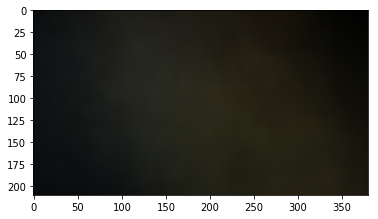

In [24]:
plt.imshow(preplot(image[0].numpy()))

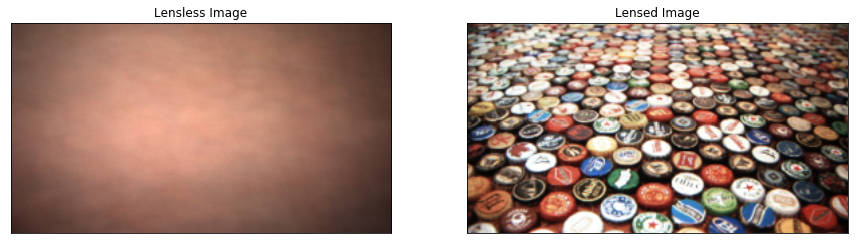

In [25]:
img_index = 8

file_path_diffuser = 'sample images/diffuser/'
file_path_lensed = 'sample images/lensed/'

files = glob.glob(file_path_diffuser + '/*.npy')


image_np = np.load(file_path_diffuser + files[img_index].split('/')[-1]).transpose((2, 0, 1))
label_np = np.load(file_path_lensed + files[img_index].split('/')[-1]).transpose((2, 0, 1))

image = torch.tensor(image_np).unsqueeze(0)
label = torch.tensor(label_np).unsqueeze(0)

# Plot sample image: 
fig1, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].imshow(preplot(image_np)/np.max(image_np)); 
ax[1].imshow(preplot(label_np)); 
ax[0].set_xticks([]); ax[0].set_yticks([]); 
ax[1].set_xticks([]); ax[1].set_yticks([]); 
ax[0].set_title('Lensless Image');  
ax[1].set_title('Lensed Image');

### Run reconstructions

In [26]:
with torch.no_grad():
    inputs = image.to(my_device)
    
    output_admm_converged = admm_auto(inputs)
    output_admm_bounded = admm_auto5(inputs)
    output_le_admm = le_admm(inputs)
    output_le_admm_s = le_admm_s(inputs)
    output_le_admm_u = le_admm_u(inputs)
    output_unet = unet(inputs)
    

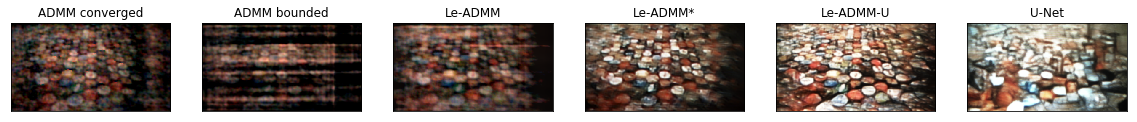

In [27]:
fig1, ax = plt.subplots(1,6,figsize=(20,10))

ax[0].imshow(preplot(output_admm_converged[0].cpu().detach().numpy()))
ax[1].imshow(preplot(output_admm_bounded[0].cpu().detach().numpy()))
ax[2].imshow(preplot(output_le_admm[0].cpu().detach().numpy()))
ax[3].imshow(preplot(output_le_admm_s[0].cpu().detach().numpy()))
ax[4].imshow(preplot(output_le_admm_u[0].cpu().detach().numpy()))
ax[5].imshow(preplot(output_unet[0].cpu().detach().numpy()))

for i in range(6):
    ax[i].set_xticks([]); ax[i].set_yticks([]); 
    
ax[0].set_title('ADMM converged');  
ax[1].set_title('ADMM bounded');
ax[2].set_title('Le-ADMM');
ax[3].set_title('Le-ADMM*');
ax[4].set_title('Le-ADMM-U');
ax[5].set_title('U-Net');

# Load untrained models

In [28]:
import admm_model as admm_model_plain
import learned_prox as learned_prox
import unet as unet_model
from ensemble import *

The shape of the loaded diffuser is:(1080, 1920, 3)


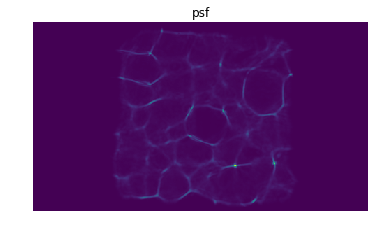

In [29]:
# Load PSF
path_diffuser = 'sample images/psf.tiff'
psf_diffuser = load_psf_image(path_diffuser, downsample=1, rgb= False)

ds = 4   # Amount of down-sampling.  Must be set to 4 to use dataset images 

print('The shape of the loaded diffuser is:' + str(psf_diffuser.shape))

psf_diffuser = np.sum(psf_diffuser,2)


h = skimage.transform.resize(psf_diffuser, 
                             (psf_diffuser.shape[0]//ds,psf_diffuser.shape[1]//ds), 
                             mode='constant', anti_aliasing=True)

plt.imshow(h); plt.axis('off'); plt.title('psf');

### Plain ADMM converged (no training)

In [30]:
var_options = {'plain_admm': [],
               'mu_and_tau': ['mus', 'tau'],
              }

learning_options_none = {'learned_vars': var_options['plain_admm']}    



admm_converged2 = admm_model_plain.ADMM_Net(batch_size = 1, h = h, iterations = 100, 
                           learning_options = learning_options_none, cuda_device = my_device)

admm_converged2.tau.data = admm_converged2.tau.data*1000
admm_converged2.to(my_device)

[]


ADMM_Net()

Text(0.5, 1.0, 'Recon, ADMM')

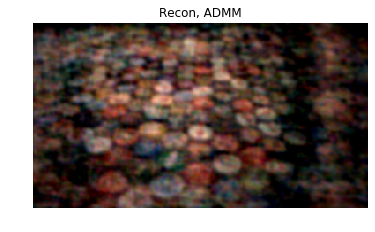

In [31]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = admm_converged2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

### Plain ADMM bounded (no training)

In [32]:
admm_bounded2 = admm_model_plain.ADMM_Net(batch_size = 1, h = h, iterations = 5, 
                           learning_options = learning_options_none, cuda_device = my_device)

admm_bounded2.tau.data = admm_bounded2.tau.data*1000
admm_bounded2.to(my_device)

[]


ADMM_Net()

Text(0.5, 1.0, 'Recon, ADMM')

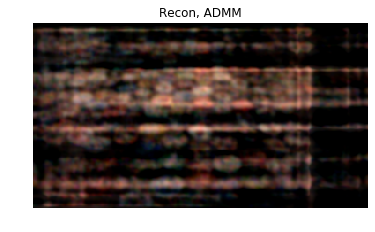

In [33]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = admm_bounded2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

### Le-ADMM 

In [34]:
learning_options_admm = {'learned_vars': var_options['mu_and_tau']} 

le_admm2 = admm_model_plain.ADMM_Net(batch_size = 1, h = h, iterations = 5, 
                           learning_options = learning_options_admm, cuda_device = my_device)

le_admm2.tau.data = le_admm2.tau.data*1000


le_admm2.to(my_device)

['mus', 'tau']


ADMM_Net()

Text(0.5, 1.0, 'Recon, ADMM')

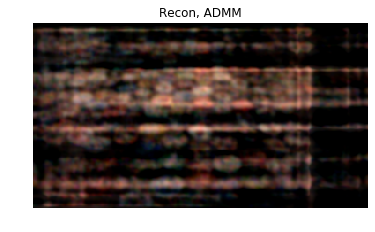

In [35]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

Now, let's load the pre-trained parameters to see how it improves the performance:

In [36]:
for pn, pd in le_admm.named_parameters():
    for pnn, pdd in le_admm2.named_parameters():
        if pnn == pn:
            pdd.data = pd.data

Text(0.5, 1.0, 'Recon, ADMM')

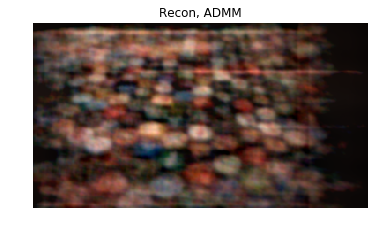

In [37]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

### Le-ADMM*

In [38]:
model_unet1 = unet_model.UNet_small((3,270,480)).to(my_device)
net_tran= learned_prox.LearnedTransform_unet(model_unet1)
net_tran.to(my_device)

le_admm_s2 = admm_model_plain.ADMM_Net(batch_size = 1, h = h, iterations = 5, 
                           learning_options = learning_options_admm, cuda_device = my_device, 
                                       le_admm_s = True, denoise_model = net_tran)


['mus', 'tau']


Text(0.5, 1.0, 'Recon, ADMM')

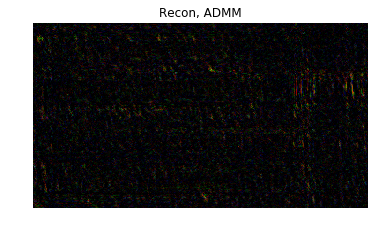

In [39]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm_s2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

In [40]:
for pn, pd in le_admm_s.named_parameters():
    for pnn, pdd in le_admm_s2.named_parameters():
        if pnn == pn:
            pdd.data = pd.data
            #print(pnn)

Text(0.5, 1.0, 'Recon, ADMM')

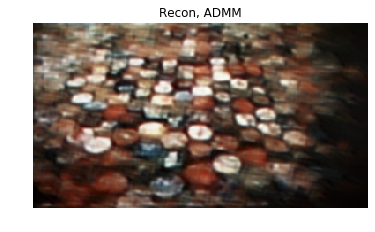

In [41]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm_s2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

### Le-ADMM-U

In [42]:
le_admm_u_admm = admm_model_plain.ADMM_Net(batch_size = 1, h = h, iterations = 5, 
                           learning_options = learning_options_admm, cuda_device = my_device)

le_admm_u_unet = unet_model.UNet270480((3,270,480))

le_admm_u2 = MyEnsemble(le_admm_u_admm, le_admm_u_unet)

['mus', 'tau']


Text(0.5, 1.0, 'Recon, ADMM')

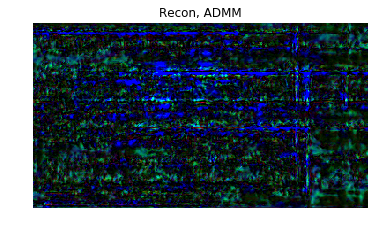

In [43]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm_u2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')

In [44]:
for pn, pd in le_admm_u.named_parameters():
    for pnn, pdd in le_admm_u2.named_parameters():
        if pnn == pn:
            pdd.data = pd.data

Text(0.5, 1.0, 'Recon, ADMM')

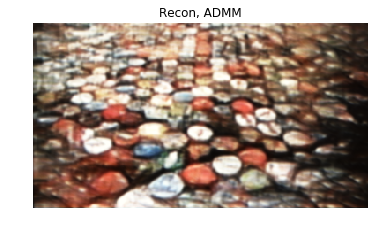

In [45]:
with torch.no_grad():
    inputs = image.to(my_device)
    output_test = le_admm_u2(inputs)

plt.imshow(preplot(output_test[0].cpu().detach().numpy())); plt.axis('off'); plt.title('Recon, ADMM')